In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

### Sea Ice Dataset



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Causal_AI_project_fall22/SeaIce-1979_2021.csv', index_col='Date') #, index_col='Time'
df = df.dropna()
df

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
Date,,,,,,,,,,
1979-01,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191
1979-02,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929
1979-03,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089
1979-04,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238
1979-05,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613
...,...,...,...,...,...,...,...,...,...,...
2021-04,5.383687,1.529497,225.171796,156.567743,1.159049,0.929777,273.470298,263.146395,985.801841,13840000
2021-05,4.777020,2.451088,260.956781,229.604138,1.077705,0.575494,273.888627,271.557464,985.606182,12660000
2021-06,4.771453,4.176458,294.931709,244.702852,1.585094,0.360146,275.245088,278.360921,978.436682,10710000


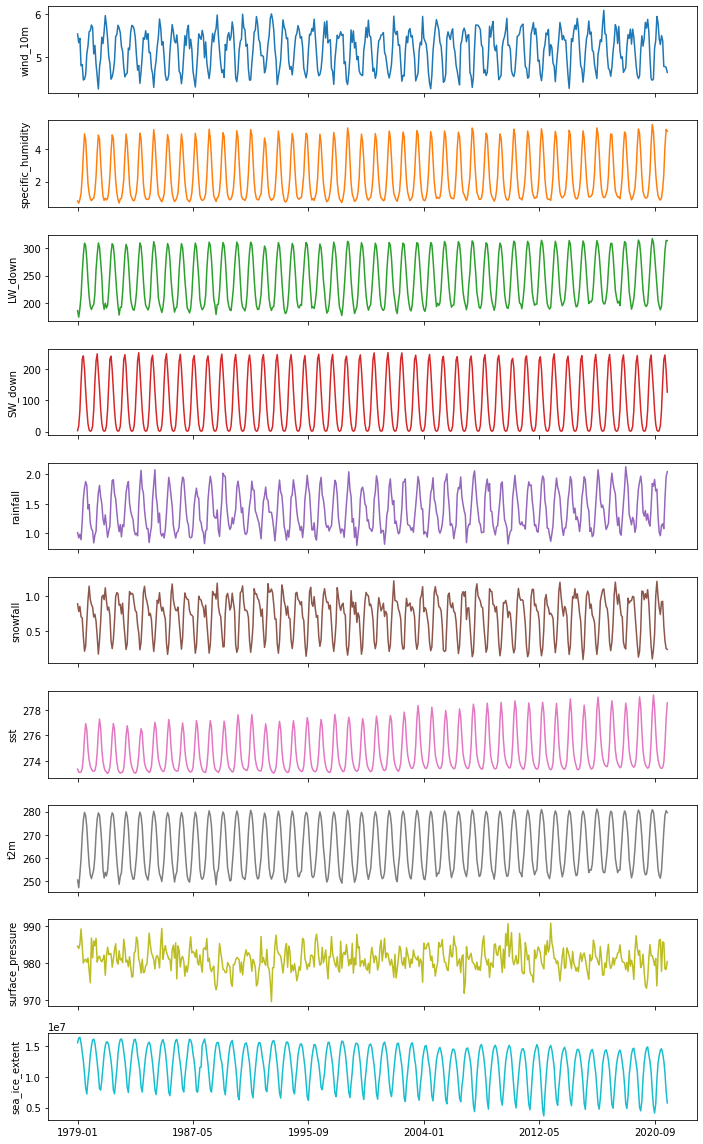

In [ ]:
fig,ax = plt.subplots(10, figsize=(10,16), sharex=True)
plot_cols = ['wind_10m', 'specific_humidity',	'LW_down',	'SW_down',	'rainfall',	'snowfall',	'sst',	't2m',	'surface_pressure',	'sea_ice_extent']
df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

## First pair of the dataset with high correlation
#### Causality between SnowFall and Sea Ice

In [ ]:
sn_si_df = df[['snowfall', 'sea_ice_extent']]
sn_si_df.head()

,snowfall,sea_ice_extent
Date,,
1979-01,0.892319,15604191
1979-02,0.781347,16378929
1979-03,0.855266,16521089
1979-04,0.705203,15561238
1979-05,0.688723,14085613


We look at the lag plots to quickly check for stationarity.

In [ ]:
def lag_plots(data_df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    lag_plot(sn_si_df[sn_si_df.columns[0]], ax=ax1)
    ax1.set_title(sn_si_df.columns[0]);

    lag_plot(sn_si_df[sn_si_df.columns[1]], ax=ax2)
    ax2.set_title(sn_si_df.columns[1]);

    ax1.set_ylabel('$y_{t+1}$');
    ax1.set_xlabel('$y_t$');
    ax2.set_ylabel('$y_{t+1}$');
    ax2.set_xlabel('$y_t$');

    plt.tight_layout()

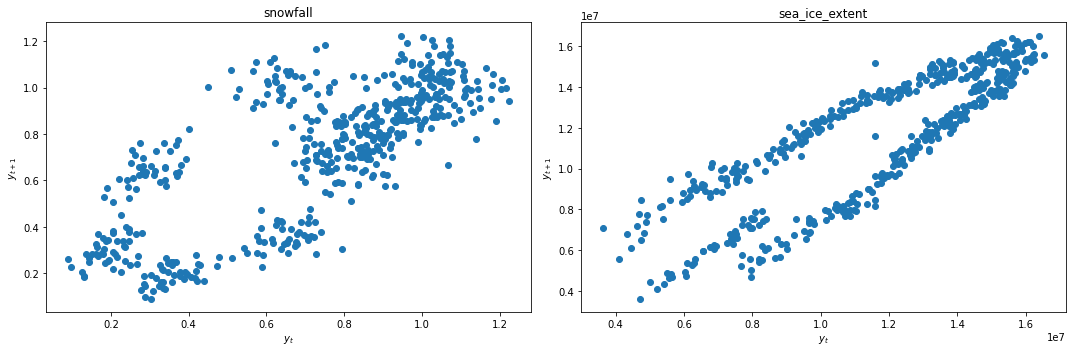

In [ ]:
lag_plots(sn_si_df)

**Result:** Either of them does not look stationary

We use KPSS and ADF tests to conclusively check for stationarity.

In [ ]:
def kpss_test(sn_si_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in sn_si_df.columns: 
        kpss_res = kpss(sn_si_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=sn_si_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [ ]:
kpss_test(sn_si_df)

,snowfall,sea_ice_extent
Test statistic,0.029,0.0261
p-value,0.100,0.1000
Critical value - 1%,0.216,0.2160
Critical value - 2.5%,0.176,0.1760
Critical value - 5%,0.146,0.1460
Critical value - 10%,0.119,0.1190


**Result:** both looks stationary as the test statistic is below p-value and critical values



In [ ]:
def adf_test(sn_si_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in sn_si_df.columns: 
        adf_res = adfuller(sn_si_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=sn_si_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [ ]:
adf_test(sn_si_df)

,snowfall,sea_ice_extent
Test statistic,-5.5112,-0.8114
p-value,0.0000,0.8158
Critical value - 1%,-3.4437,-3.4435
Critical value - 5%,-2.8674,-2.8673
Critical value - 10%,-2.5699,-2.5699


**Result:** Snowfall is stationary but sea-ice is not.

Since both the lag plot and ADF test indicate that sea ice is not stationary, we apply differencing first before building our VAR model.

In [ ]:
sn_si_df['sea_ice_extent'] = sn_si_df['sea_ice_extent'] - sn_si_df['sea_ice_extent'].shift(2)
sn_si_df['snowfall'] = sn_si_df['snowfall'] - sn_si_df['snowfall'].shift(2)
sn_si_df = sn_si_df.dropna()

We again look at the lag plots and apply the KPSS and ADF tests.

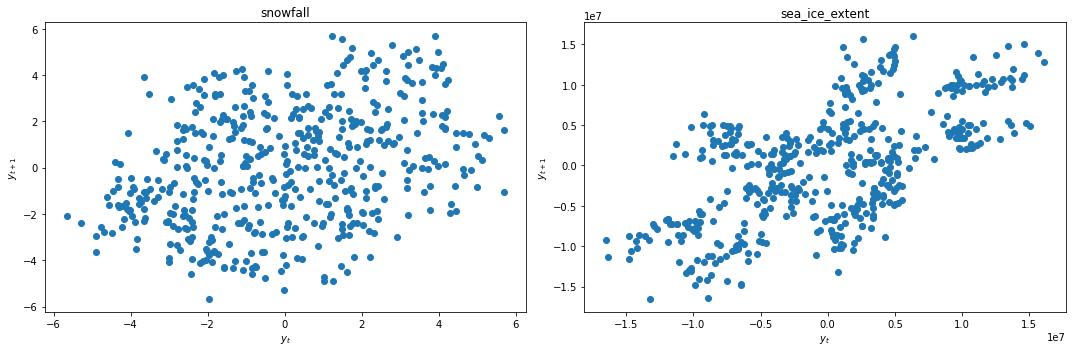

In [ ]:
lag_plots(sn_si_df)

In [ ]:
kpss_test(sn_si_df)

,snowfall,sea_ice_extent
Test statistic,0.0186,0.0201
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [ ]:
adf_test(sn_si_df)

,snowfall,sea_ice_extent
Test statistic,-6.9219,-12.1748
p-value,0.0000,0.0000
Critical value - 1%,-3.4438,-3.4435
Critical value - 5%,-2.8675,-2.8674
Critical value - 10%,-2.5699,-2.5699


**Result:** Tests conclusively agree that both data are now stationary.

We next split the data into train and test sets for the VAR model.

In [ ]:
def splitter(sn_si_df):
    end = round(len(sn_si_df)*.8)
    train_df = sn_si_df[:end]
    test_df = sn_si_df[end:]
    return train_df, test_df

In [ ]:
train_df, test_df = splitter(sn_si_df)

We then select the VAR order $p$ by computing the different multivariate information criteria (AIC, BIC, HQIC), and FPE.

In [ ]:
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     34
BIC     12
HQIC    24
FPE     34
dtype: int64


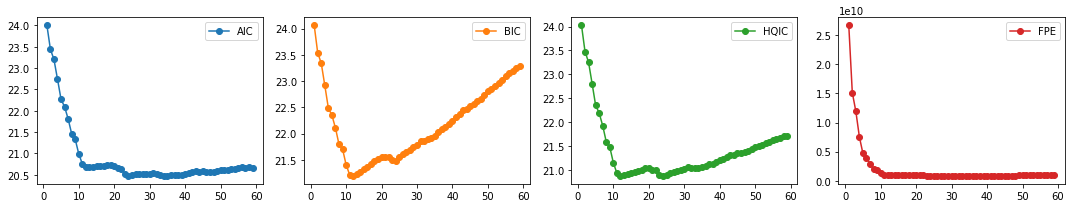

In [ ]:
select_p(train_df)

We now fit the VAR model with the chosen order.

In [ ]:
p = 22
model = VAR(train_df)
var_model = model.fit(p)

We can finally test the variables for Granger Causality

In [ ]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
granger_causation_matrix(train_df, train_df.columns, p)  

,snowfall_x,sea_ice_extent_x
snowfall_y,1.0,0.0
sea_ice_extent_y,0.0,1.0


**Recall:** If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

**Results:** For this particular example, we can say that Snowfall Granger causes changes in the se_ice_extent. This means that Snowfall data improves changes in Sea Ice level prediction performance.

On the other hand, Sea Ice Granger cause Snowfall too. This means that changes in sea ice data improves Snowfall prediction performance.

# Second pair of variable test

#### Causality between wind_10m and Sea Ice

In [ ]:
wi_si_df = df[['wind_10m', 'sea_ice_extent']]
wi_si_df.head()

,wind_10m,sea_ice_extent
Date,,
1979-01,5.531398,15604191
1979-02,5.328020,16378929
1979-03,5.432511,16521089
1979-04,4.792836,15561238
1979-05,4.819028,14085613


We look at the lag plots to quickly check for stationarity.

In [ ]:
def lag_plots(data_df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    lag_plot(wi_si_df[wi_si_df.columns[0]], ax=ax1)
    ax1.set_title(wi_si_df.columns[0]);

    lag_plot(wi_si_df[wi_si_df.columns[1]], ax=ax2)
    ax2.set_title(wi_si_df.columns[1]);

    ax1.set_ylabel('$y_{t+1}$');
    ax1.set_xlabel('$y_t$');
    ax2.set_ylabel('$y_{t+1}$');
    ax2.set_xlabel('$y_t$');

    plt.tight_layout()

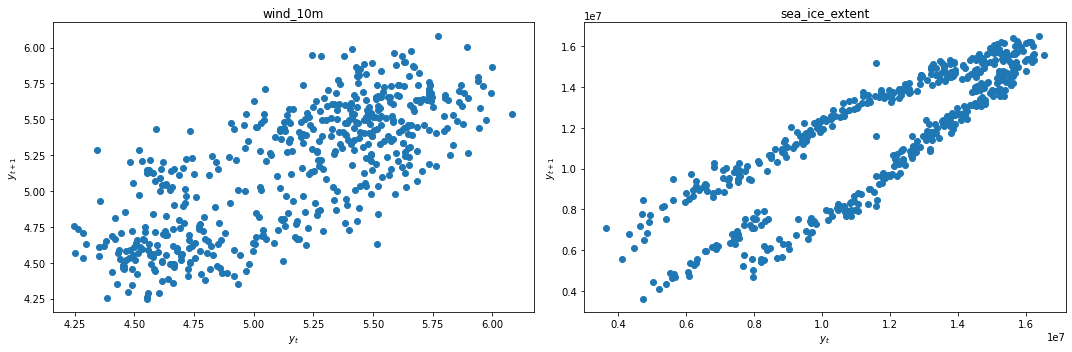

In [ ]:
lag_plots(wi_si_df)

**Result:** Either of them does not look stationary

We use KPSS and ADF tests to conclusively check for stationarity.

In [ ]:
def kpss_test(wi_si_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in wi_si_df.columns: 
        kpss_res = kpss(wi_si_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=wi_si_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [ ]:
kpss_test(wi_si_df)

,wind_10m,sea_ice_extent
Test statistic,0.0368,0.0261
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


**Result:**??


In [ ]:
def adf_test(wi_si_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in wi_si_df.columns: 
        adf_res = adfuller(wi_si_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=wi_si_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [ ]:
adf_test(wi_si_df)

,wind_10m,sea_ice_extent
Test statistic,-4.4865,-0.8114
p-value,0.0002,0.8158
Critical value - 1%,-3.4437,-3.4435
Critical value - 5%,-2.8674,-2.8673
Critical value - 10%,-2.5699,-2.5699


**Result:** ??

Since both the lag plot and ADF test indicate that sea ice is not stationary, we apply differencing first before building our VAR model.

In [ ]:
wi_si_df['sea_ice_extent'] = wi_si_df['sea_ice_extent'] - wi_si_df['sea_ice_extent'].shift(1)
wi_si_df['wind_10m'] = wi_si_df['wind_10m'] - wi_si_df['wind_10m'].shift(2)
wi_si_df = wi_si_df.dropna()

We again look at the lag plots and apply the KPSS and ADF tests.

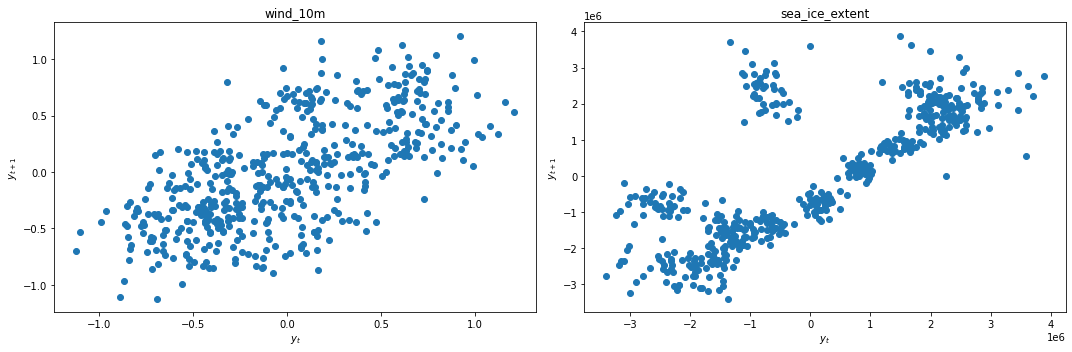

In [ ]:
lag_plots(wi_si_df)

In [ ]:
kpss_test(wi_si_df)

,wind_10m,sea_ice_extent
Test statistic,0.0173,0.0201
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [ ]:
adf_test(wi_si_df)

,wind_10m,sea_ice_extent
Test statistic,-6.7586,-12.1748
p-value,0.0000,0.0000
Critical value - 1%,-3.4438,-3.4435
Critical value - 5%,-2.8675,-2.8674
Critical value - 10%,-2.5699,-2.5699


**Result:** All three conclusively agree that both data are not stationary!

We next split the data into train and test sets for the VAR model.

In [ ]:
def splitter(wi_si_df):
    end = round(len(wi_si_df)*.8)
    train_df = wi_si_df[:end]
    test_df = wi_si_df[end:]
    return train_df, test_df

In [ ]:
train_df, test_df = splitter(wi_si_df)

We then select the VAR order $p$ by computing the different multivariate information criteria (AIC, BIC, HQIC), and FPE.

In [ ]:
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     24
BIC     12
HQIC    12
FPE     24
dtype: int64


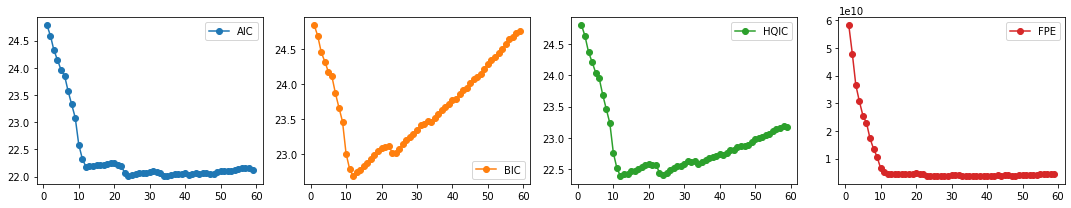

In [ ]:
select_p(train_df)

We now fit the VAR model with the chosen order.

In [ ]:
p = 23
model = VAR(train_df)
var_model = model.fit(p)

We can finally test the variables for Granger Causality

In [ ]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
granger_causation_matrix(train_df, train_df.columns, p)  

,wind_10m_x,sea_ice_extent_x
wind_10m_y,1.0,0.0
sea_ice_extent_y,0.0,1.0


**Recall:** If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

**Results:** For this particular example, we can say that Snowfall Granger causes changes in the se_ice_extent. This means that Snowfall data improves changes in Sea Ice level prediction performance.

On the other hand, Sea Ice Granger cause Snowfall too. This means that changes in sea ice data improves Snowfall prediction performance.

### 3rd pair of varibale test

#### Causality between SnowFall and Sea Ice

In [ ]:
ss_si_df = df[['sst', 'sea_ice_extent']]
ss_si_df.head()

,sst,sea_ice_extent
Date,,
1979-01,273.355237,15604191
1979-02,273.121885,16378929
1979-03,273.088099,16521089
1979-04,273.126062,15561238
1979-05,273.393551,14085613


We look at the lag plots to quickly check for stationarity.

In [ ]:
def lag_plots(ss_si_df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    lag_plot(ss_si_df[ss_si_df.columns[0]], ax=ax1)
    ax1.set_title(ss_si_df.columns[0]);

    lag_plot(ss_si_df[ss_si_df.columns[1]], ax=ax2)
    ax2.set_title(ss_si_df.columns[1]);

    ax1.set_ylabel('$y_{t+1}$');
    ax1.set_xlabel('$y_t$');
    ax2.set_ylabel('$y_{t+1}$');
    ax2.set_xlabel('$y_t$');

    plt.tight_layout()

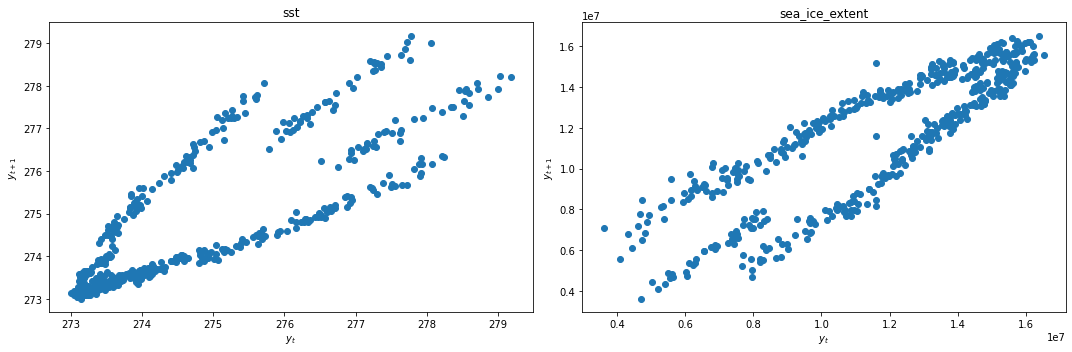

In [ ]:
lag_plots(ss_si_df)

**Result:** ??

We use KPSS and ADF tests to conclusively check for stationarity.

In [ ]:
def kpss_test(ss_si_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in ss_si_df.columns: 
        kpss_res = kpss(ss_si_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=ss_si_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [ ]:
kpss_test(ss_si_df)

,sst,sea_ice_extent
Test statistic,0.0318,0.0261
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [ ]:
def adf_test(ss_si_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in ss_si_df.columns: 
        adf_res = adfuller(ss_si_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=ss_si_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [ ]:
adf_test(ss_si_df)

,sst,sea_ice_extent
Test statistic,-1.3730,-0.8114
p-value,0.5951,0.8158
Critical value - 1%,-3.4435,-3.4435
Critical value - 5%,-2.8673,-2.8673
Critical value - 10%,-2.5699,-2.5699


**Result:** Snowfall is stationary but sea-ice is not.

Since both the lag plot and ADF test indicate that sea ice is not stationary, we apply differencing first before building our VAR model.

In [ ]:
ss_si_df['sea_ice_extent'] = ss_si_df['sea_ice_extent'] - ss_si_df['sea_ice_extent'].shift(6)
ss_si_df['sst'] = ss_si_df['sst'] - ss_si_df['sst'].shift(6)
ss_si_df = ss_si_df.dropna()

We again look at the lag plots and apply the KPSS and ADF tests.

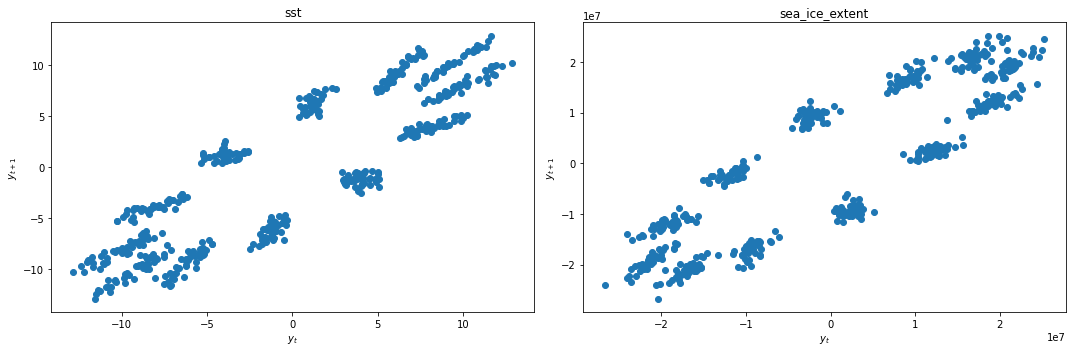

In [ ]:
lag_plots(ss_si_df)

In [ ]:
kpss_test(ss_si_df)

,sst,sea_ice_extent
Test statistic,0.0191,0.0185
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [ ]:
adf_test(ss_si_df)

,sst,sea_ice_extent
Test statistic,-7.4255,-12.0638
p-value,0.0000,0.0000
Critical value - 1%,-3.4438,-3.4435
Critical value - 5%,-2.8675,-2.8673
Critical value - 10%,-2.5699,-2.5699


**Result:** All three conclusively agree that both data are now stationary.

We next split the data into train and test sets for the VAR model.

In [ ]:
def splitter(ss_si_df):
    end = round(len(ss_si_df)*.8)
    train_df = ss_si_df[:end]
    test_df = ss_si_df[end:]
    return train_df, test_df

In [ ]:
train_df, test_df = splitter(ss_si_df)

We then select the VAR order $p$ by computing the different multivariate information criteria (AIC, BIC, HQIC), and FPE.

In [ ]:
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     23
BIC     11
HQIC    11
FPE     23
dtype: int64


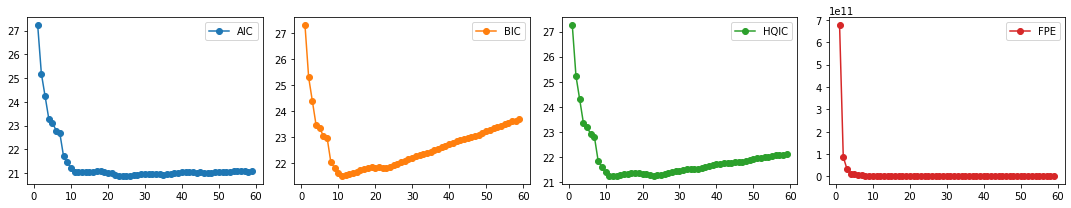

In [ ]:
select_p(train_df)

We now fit the VAR model with the chosen order.

In [ ]:
p = 26
model = VAR(train_df)
var_model = model.fit(p)

We can finally test the variables for Granger Causality

In [ ]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
granger_causation_matrix(train_df, train_df.columns, p)  

,sst_x,sea_ice_extent_x
sst_y,1.0,0.0
sea_ice_extent_y,0.0,1.0


**Recall:** If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

## References

The contents of this notebook are compiled from the following references:

* [Granger, C. (1969). Investigating Causal Relations by Econometric Models and Cross-spectral Methods. Econometrica, 37(3), 424-438.](https://www.jstor.org/stable/1912791)
* [Toda, Hiro Y. & Yamamoto, Taku (1995). Statistical inference in vector autoregressions with possibly integrated processes. Journal of Econometrics, 66(1-2), 225-250.](https://ideas.repec.org/a/eee/econom/v66y1995i1-2p225-250.html)
* [Hood, M., Kidd, Q., & Morris, I. (2008). Two Sides of the Same Coin? Employing Granger Causality Tests in a Time Series Cross-Section Framework. Political Analysis, 16(3), 324-344.](https://www.jstor.org/stable/25791939)
* [Testing for Granger Causality Using Python](https://rishi-a.github.io/2020/05/25/granger-causality.html)